# Reading data and initializing

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\Apps\spark-3.3.1-bin-hadoop3\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [6]:
import pandas as pd
df=pd.read_csv("XYZ_Bank_Deposit_Data_Classification.csv",sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
df = df.rename(columns={"emp.var.rate": "emp_var_rate","cons.price.idx": "cons_price_idx","nr.employed":"nr_employed"})
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons.conf.idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Data Exploration

In [10]:
df_s=df.describe().transpose()
df_s

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp_var_rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons_price_idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr_employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


In [13]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons.conf.idx     float64
euribor3m         float64
nr_employed       float64
y                  object
dtype: object

In [16]:
for i in df.dtypes:
    if i!=object:

int64
object
object
object
object
object
object
object
object
object
int64
int64
int64
int64
object
float64
float64
float64
float64
float64
object


In [41]:
# total numeric variables
df_num = df.select_dtypes(include=['int64','float64'])
df_num


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons.conf.idx,euribor3m,nr_employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6


In [42]:
# total string variables
df_cat = df.select_dtypes(include=['object'])
df_cat.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,no
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,no


In [26]:
# split the preprocessed data into training and split datasets
train_df= df.sample(frac=0.8, random_state=2018)
test_df = df.drop(train_df.index)
train_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons.conf.idx,euribor3m,nr_employed,y
19607,47,management,married,high.school,no,no,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.968,5228.1,no
18843,58,blue-collar,married,basic.9y,no,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.970,5228.1,no
3476,34,blue-collar,married,basic.9y,no,yes,no,telephone,may,thu,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
21897,31,admin.,married,university.degree,no,no,no,cellular,aug,wed,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
10906,38,blue-collar,married,basic.9y,unknown,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,39,unemployed,single,basic.9y,unknown,yes,no,telephone,may,fri,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
247,36,technician,single,high.school,no,yes,no,telephone,may,mon,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
15970,43,admin.,married,high.school,no,yes,no,cellular,jul,mon,...,28,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no
23137,50,admin.,divorced,university.degree,no,no,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no


In [27]:
#PCA on numeric train data
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
train_df_num_scaled=sc.fit_transform(train_df[df_num.columns])
test_df_num_scaled=sc.transform(test_df[df_num.columns])
train_df_num_scaled

array([[ 0.66915278,  0.06336426, -0.56588049, ...,  0.95267285,
         0.77947737,  0.84737156],
       [ 1.72469205,  0.91014344, -0.56588049, ...,  0.95267285,
         0.78062973,  0.84737156],
       [-0.57830272, -0.24178139,  0.52118806, ...,  0.88789362,
         0.71724989,  0.33389793],
       ...,
       [ 0.28532032, -0.89784455,  9.21773647, ..., -0.47247031,
         0.77486792,  0.84737156],
       [ 0.95702712, -0.49352656, -0.56588049, ...,  0.95267285,
         0.77774883,  0.84737156],
       [ 0.47723655,  0.37613855,  2.69532516, ...,  0.88789362,
         0.71724989,  0.33389793]])

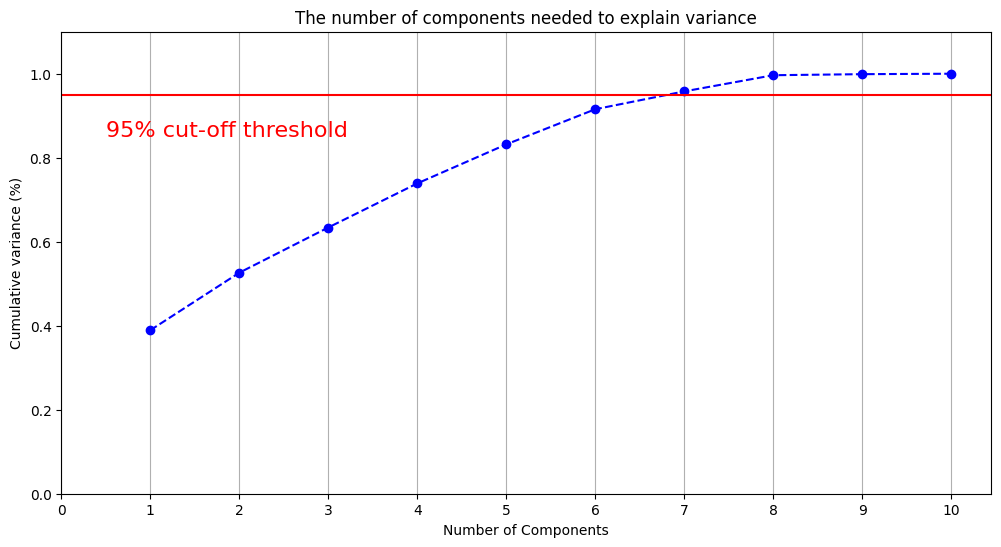

In [29]:
import sklearn
from sklearn.decomposition import PCA
pca = PCA().fit(train_df_num_scaled)


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()


In [30]:
pca=PCA(n_components=8, random_state=0)
train_num_pca=pca.fit_transform(train_df_num_scaled)
test_num_pca=pca.transform(test_df_num_scaled)
pca.explained_variance_ratio_ *100

array([38.92776422, 13.68695032, 10.77147609, 10.49514445,  9.29259869,
        8.36980401,  4.24992899,  3.8513835 ])

In [40]:
df_pca_train.to_csv('train_pca_scaled.csv')
df_pca_test.to_csv('test_pca_scaled.csv')

In [36]:
df_pca_train=pd.concat([pd.DataFrame(train_num_pca,columns=['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8']),train_df[df_cat.columns].reset_index(drop=True)],axis=1)
df_pca_train

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,-1.297713,0.498168,-1.201673,0.167336,-0.332698,0.060501,-0.594094,0.079607,management,married,high.school,no,no,no,cellular,aug,thu,nonexistent,no
1,-1.274105,0.858610,-1.913234,0.528991,0.629166,-0.306009,-0.656456,0.093964,blue-collar,married,basic.9y,no,no,no,cellular,aug,mon,nonexistent,no
2,-1.393689,0.320339,0.229150,-0.282603,-0.306398,0.846180,0.441611,0.057695,blue-collar,married,basic.9y,no,yes,no,telephone,may,thu,nonexistent,no
3,-1.308090,0.058615,-0.230309,0.349984,-1.185060,0.802121,-0.535127,0.090910,admin.,married,university.degree,no,no,no,cellular,aug,wed,nonexistent,no
4,-1.842108,0.138672,0.505235,-0.013636,-0.888739,-0.922602,0.536438,-0.100867,blue-collar,married,basic.9y,unknown,yes,no,telephone,jun,wed,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,-1.276367,0.484932,-0.455130,0.371382,-0.646180,0.207634,0.421339,0.040736,unemployed,single,basic.9y,unknown,yes,no,telephone,may,fri,nonexistent,no
32946,-1.324902,0.363466,-0.123560,-0.082293,-0.797519,0.408463,0.444213,0.035945,technician,single,high.school,no,yes,no,telephone,may,mon,nonexistent,no
32947,-2.458350,-0.229310,3.394927,-5.787695,5.423019,2.834396,-0.216478,0.035543,admin.,married,high.school,no,yes,no,cellular,jul,mon,nonexistent,no
32948,-1.310386,0.524047,-1.341637,-0.336721,-0.535076,-0.216770,-0.583555,0.056009,admin.,divorced,university.degree,no,no,no,cellular,aug,tue,nonexistent,no


In [37]:
df_pca_test=pd.concat([pd.DataFrame(test_num_pca,columns=['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8']),test_df[df_cat.columns].reset_index(drop=True)],axis=1)
df_pca_test

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,-1.267822,0.940592,-1.478827,0.083909,0.187520,-0.607814,0.363166,0.024409,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,no
1,-1.283485,0.959044,-1.613021,-0.484275,-0.064480,-0.903960,0.376219,-0.002009,admin.,married,professional.course,no,no,no,telephone,may,mon,nonexistent,no
2,-1.288378,0.344571,-0.189231,0.160355,-1.057427,0.317509,0.447256,0.031986,blue-collar,married,basic.6y,no,yes,no,telephone,may,mon,nonexistent,no
3,-1.272213,0.402535,-0.232715,0.644678,-0.683840,0.460006,0.425471,0.054006,blue-collar,married,basic.6y,no,yes,no,telephone,may,mon,nonexistent,no
4,-1.287964,0.942982,-1.600971,-0.618484,-0.168004,-0.943447,0.382256,-0.008111,technician,married,unknown,no,yes,no,telephone,may,mon,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8233,1.803783,-0.988905,1.284261,0.892991,0.605921,-1.753941,3.115510,-0.613101,housemaid,divorced,high.school,no,yes,yes,cellular,nov,thu,nonexistent,no
8234,1.603382,-0.609989,0.837583,-1.314573,2.007757,-2.193608,3.086669,-0.641249,retired,married,professional.course,no,yes,no,cellular,nov,thu,nonexistent,no
8235,1.717585,-0.404641,0.042625,-0.803011,1.682193,-2.960046,3.064221,-0.665011,retired,divorced,professional.course,no,yes,no,cellular,nov,fri,nonexistent,no
8236,1.810230,-0.098569,-0.787970,-0.093228,2.018540,-3.548817,3.014361,-0.664870,retired,married,professional.course,no,yes,no,cellular,nov,fri,nonexistent,yes


# Pre-processing and feature engineering

In [15]:
# For the string features
stages = []
for col in string_features[:-1]:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + 'coded')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "classVec"])
    stages += [stringIndexer, encoder]

# for the outcome label
label_string = StringIndexer(inputCol= 'y', outputCol='label')
stages += [label_string]

# for the numerical columns as well
assemblerInputs = [c + 'classVec' for c in string_features[:-1]] + numeric_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='vectorized_features', handleInvalid='skip')
stages += [assembler]

# scale down the features into something usable
scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')
stages += [scaler]

In [16]:
df1 = df
cols = df1.columns
pipeline = Pipeline(stages=stages)
pipelinemodel = pipeline.fit(df1)
df1 = pipelinemodel.transform(df1)
selectedCols = ['label', 'features'] + cols
df2 =df1.select(selectedCols)
df2.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



# Data split

In [17]:
# split the preprocessed data into training and split datasets
train, test = df2.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32894
Test Dataset Count: 8294


# Logistic Regression

In [21]:
# training for the logistic regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.594425351090118, -3.594425351090118]",0.0,"[0.9732582995140778, 0.02674170048592217]"
1,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4378468979268284, -3.4378468979268284]",0.0,"[0.9688666350236456, 0.03113336497635444]"
2,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.0909583948671973, -3.0909583948671973]",0.0,"[0.9565182431800154, 0.04348175681998456]"
3,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[4.1780880493561465, -4.1780880493561465]",0.0,"[0.9849036087098789, 0.01509639129012108]"
4,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[2.805009494065649, -2.805009494065649]",0.0,"[0.9429459281735608, 0.05705407182643918]"


In [22]:
# confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 393  538]
 [ 208 7155]]


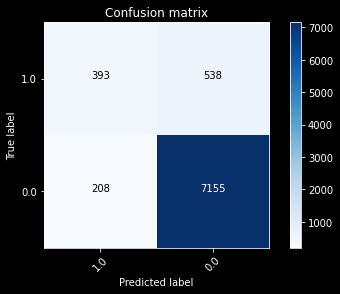

In [23]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [24]:
# model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9100554617795997


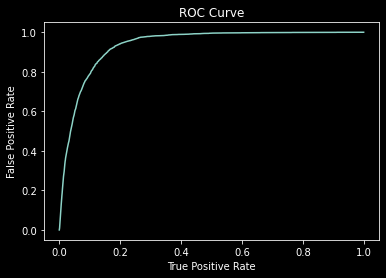

Training set area under ROC: 0.9352660044260754


In [28]:
# training ROC for the model
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set area under ROC: ' + str(trainingSummary.areaUnderROC))

In [29]:
# testing ROC for model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9368305661614329


# Cross Validation

In [30]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])# regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])# Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, [1, 5, 10])#Number of iterations
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)

In [31]:
## Evaluate Best Model
predictions = cvModel.transform(test)
print('Best Model Test Area Under ROC', evaluator.evaluate(predictions))

Best Model Test Area Under ROC 0.9367999313780854


In [32]:
cvModel.bestModel.explainParams().split("\n")

['aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)',
 'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.5)',
 'family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)',
 'featuresCol: features column name. (default: features, current: features)',
 'fitIntercept: whether to fit an intercept term. (default: True)',
 'labelCol: label column name. (default: label, current: label)',
 'lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)',
 'lowerBoundsOnIntercepts: The lower bounds on intercepts if fitti